## Import and Exploration

We'll start by importing the data and taking a look at the dataframe in pandas. Taking a quick gander at the file, there was no extension, but it seems values are comma delimited and the headers were provided in the markdown, so we'll use pandas' read utilities to get a dataframe up and running.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

np.random.seed(8)

In [2]:
df = pd.read_csv('../data/p13-takehome-ml/sampled_training', sep=',')
df.columns = ['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', \
              'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',\
             'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

In [3]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10002028568167339219,0,14102100,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,58811cdf,8326c04b,1,2,20596,320,50,2161,0,35,100148,157
1,10006958186789044052,1,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,f95efa07,a99f214a,ce6e6bbd,2cd8ff6d,1,0,18993,320,50,2161,0,35,100034,157
2,10011650513707909570,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,1ce4451d,99e427c9,1,0,21611,320,50,2480,3,297,100111,61
3,10022961149355219548,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,bd7c02a1,51197d98,2203a096,1,0,4687,320,50,423,2,39,100148,32
4,10029289556764215760,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1c306e3a,ff065cf0,1,2,15706,320,50,1722,0,35,100084,79


In [4]:
df.shape

(843502, 24)

Alright, we have the data loaded and I can see that we are dealing with banner ads data, which is great news! As it turns out, my last position was as a Search Engine Marketing Analyst and my specialty was in display advertisements. The columns have some columns that are familiar and some that are forceably unfamiliar (see the C's).

Before getting started, my intuition tells me that id, hour, and banner_pos are going to be among our most predictive variables for click prediction. We'll need to engineer a column with hour that contains just that hour and not the datetime. Also, there are several variables that are nominal and so we'll have to encode them. We'll also expect a lot of information gain from both device_type and app_domain. We'll file all that in the back of our head and do some quick checks to make sure we're working with clean data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843502 entries, 0 to 843501
Data columns (total 24 columns):
id                  843502 non-null uint64
click               843502 non-null int64
hour                843502 non-null int64
C1                  843502 non-null int64
banner_pos          843502 non-null int64
site_id             843502 non-null object
site_domain         843502 non-null object
site_category       843502 non-null object
app_id              843502 non-null object
app_domain          843502 non-null object
app_category        843502 non-null object
device_id           843502 non-null object
device_ip           843502 non-null object
device_model        843502 non-null object
device_type         843502 non-null int64
device_conn_type    843502 non-null int64
C14                 843502 non-null int64
C15                 843502 non-null int64
C16                 843502 non-null int64
C17                 843502 non-null int64
C18                 843502 non-null int

In [6]:
df.isnull().values.any()

False

In [7]:
df.id.unique().shape

(843502,)

So, now we know that we don't have hidden null values and that some of our data types need to be corrected. We also found that id was not what we had originally planned for. The markdown lists this as "ad identifier", which I took to mean something similar to a categorical with described the banner asset being displayed (which usually has a lot to do with why people click). It seems that it is simply a unique identifier for the impression, and so we'll de-prioritize this feature.

For the sake of getting a first model up and running, we'll create an hour_of_day feature using string indexing.

In [8]:
hod = lambda x: int(str(x)[-2:])
df['hour_of_day'] = df.hour.apply(hod)

## First Model

Okay, now we're ready to get a classifier up and running. I'm going to use sklearn's random forest classifier for a couple of reasons. Random forest models are easy to get up and running and usually have strong predictability out of the gate. It is also difficult to overfit Random forest models which is an upside given that we have a sizeable dataset. 

We'll select as many of the variables that we deem important (so excluding the anonymous variables for now) as well currently can in order to establish a baseline. We'll also be using sklearn's train_test_split to create a validation set.

In [9]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,10002028568167339219,0,14102100,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,58811cdf,8326c04b,1,2,20596,320,50,2161,0,35,100148,157,0
1,10006958186789044052,1,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,f95efa07,a99f214a,ce6e6bbd,2cd8ff6d,1,0,18993,320,50,2161,0,35,100034,157,0
2,10011650513707909570,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,1ce4451d,99e427c9,1,0,21611,320,50,2480,3,297,100111,61,0
3,10022961149355219548,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,bd7c02a1,51197d98,2203a096,1,0,4687,320,50,423,2,39,100148,32,0
4,10029289556764215760,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1c306e3a,ff065cf0,1,2,15706,320,50,1722,0,35,100084,79,0


In [10]:
X = df[['banner_pos', 'device_type', 'device_conn_type', 'hour_of_day']]
y = df['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [11]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print("Score: ", clf.score(X_test, y_test))

Score:  0.8299012459840429


We'll also try sklearn's logistic regression out of curiosity before go further with random forests. I have little expectation that logistic regression will out perform random forests, but we'll see what we get.

In [12]:
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
print('Score: ', log_clf.score(X_test, y_test))

/Users/austinmadert/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score:  0.8298538250880251


Not bad for our first models with no tuning and few features. And Logistic Regression performed very similar to random forest, however, we'll stick with the random forest model.

I'm now curious to see if we can try adding in any of the known categories that have alphanumeric values. We'll need to encode them. Which, it must be said, is potentially limiting the features we should be willing to use in our model. We cannot assume that our list of site_ids is exhaustive as the web is constantly growing. And so, the minute we collect a new piece of data about a new site, our model will break. Same goes for app_id and I'm going to lump the domain features in as well. I'm more confident that categories will remain stable for long enough to get good use from a model.

In [13]:
# Checking all variables to find which are categorical
for column in df.columns:
    print(column, len(df[column].unique()))

id 843502
click 2
hour 217
C1 7
banner_pos 7
site_id 2366
site_domain 2506
site_category 21
app_id 2211
app_domain 156
app_category 28
device_id 78975
device_ip 153806
device_model 4415
device_type 4
device_conn_type 4
C14 2019
C15 8
C16 9
C17 390
C18 4
C19 64
C20 158
C21 55
hour_of_day 24


Out of all our features, it seems the majority are categorical. We'll use integer encoding as that should work fine for our purposes here. We'll skip encoding anything with more than 100 unique values out of a conservative fear of using anything with continuous like data or for our reasons above of new unseen data.

In [14]:
enc = LabelEncoder()

#create new dataframe for training to keep namespace organized
new_df = df[['click', 'banner_pos', 'device_type', 'device_conn_type', 'hour_of_day']].copy()

cols_to_encode = ['site_category', 'app_category', 'C15', 'C16', 'C18', 'C19', 'C21']

#encode each category column and add it to the new dataframe
for col in cols_to_encode:
    new_df[col] = pd.Series(enc.fit_transform(df[col]))
    
new_df.head()

,click,banner_pos,device_type,device_conn_type,hour_of_day,site_category,app_category,C15,C16,C18,C19,C21
0,0,0,1,2,0,19,0,3,2,0,2,40
1,1,0,1,0,0,5,26,3,2,0,2,40
2,0,0,1,0,0,5,4,3,2,3,19,16
3,0,0,1,0,0,5,4,3,2,2,4,7
4,0,0,1,2,0,1,0,3,2,0,2,21


## Second Model

Let's try our random forest on the new expanded feature set

In [15]:
y = new_df.pop('click')
X = new_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print("Score: ", clf.score(X_test, y_test))

Score:  0.8332444191532999


We've improved! Let's also try a bit of tuning, by switching the random forest's max_features setting to 'sqrt'. This parameter usually works best on classification problems.

In [19]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
clf.fit(X_train, y_train)
print("Score: ", clf.score(X_test, y_test))

Score:  0.8333036952733222


It seems the setting change may have nudged us in the right direction. We'll keep it moving forward. Let's take a look at our feature importances

In [20]:
for name, importance in zip(new_df.columns, clf.feature_importances_):
    print(name, importance)

banner_pos 0.032630961130294456
device_type 0.017602262602455492
device_conn_type 0.03573441628906895
hour_of_day 0.2608270150936071
site_category 0.0958358880031002
app_category 0.07835065902456909
C15 0.051818206759404906
C16 0.08865608244548788
C18 0.06530790569728687
C19 0.12367958544451707
C21 0.14955701751020795


It looks as though our hour_of_day feature is the most important feature for information gain. It also seems that some of the anonymous variables are contributing heavily to our predictions. I'm somewhat surprised to see device_type play such a small role in whether people click.

Next let's make a plot of the error of increasingly large forests. I'd like to get a sense if we are hitting a wall with the n_estimators, or if we're still improving by increasing n_estimators. 

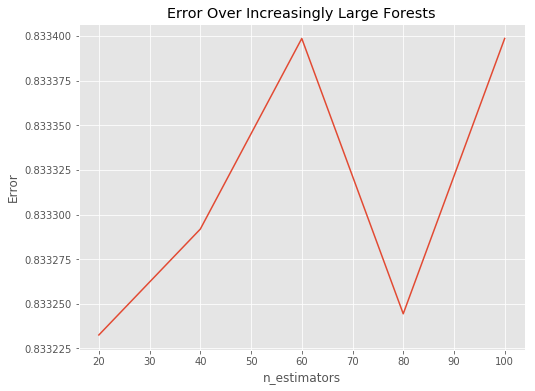

In [23]:
result = []
forest_sizes = [20, 40, 60, 80, 100]

for forest_size in forest_sizes:
    clf = RandomForestClassifier(n_estimators=forest_size, max_features='sqrt')
    clf.fit(X_train, y_train)
    result.append(clf.score(X_test, y_test))
    
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(forest_sizes, result)
ax.set_title('Error Over Increasingly Large Forests')
ax.set_xlabel('n_estimators')
ax.set_ylabel('Error');

It seems we're getting negligible differences in our improvement. In total our results span less than a percent difference in the error. We'll use the 60 tree model and generate our output using the predict_proba method as the markdown prompts us to specifically return the probability of a click for each test case.

In [24]:
# Use all the sampled data to train
clf = RandomForestClassifier(n_estimators=60, max_features='sqrt')
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
test_data = pd.read_csv('../data/p13-takehome-ml/sampled_test', sep=',')
test_data.columns = ['id', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', \
              'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',\
             'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

In [29]:
test_data.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,6360170755674123511,14103000,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,235dacaa,84ebbcd4,1,0,17614,320,50,1993,2,1063,-1,33
1,6372531204453459606,14103000,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,d5ac81e5,7fb42699,1,0,23726,320,50,2717,2,47,-1,23
2,6375797800199782003,14103000,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e5354ca2,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,638604204480092601,14103000,1005,0,7294ea0f,863fa89d,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,a9d89cf9,779d90c2,1,0,17239,320,50,1973,3,39,-1,23
4,6386958778120101437,14103000,1005,0,85f751fd,c4e18dd6,50e219e0,c8e3e3c1,b5f3b24a,8ded1f7a,0069fcd3,fb816716,2c5339cd,1,2,21667,320,50,2494,3,39,-1,112


In [32]:
# recompute the hour_of_day feature
test_data['hour_of_day'] = test_data.hour.apply(hod)

# Encode the test data in the same way as the training data
enc_test_df = test_data[['banner_pos', 'device_type', 'device_conn_type', 'hour_of_day']].copy()

cols_to_encode = ['site_category', 'app_category', 'C15', 'C16', 'C18', 'C19', 'C21']

# encode each category column and add it to the new dataframe
for col in cols_to_encode:
    enc_test_df[col] = pd.Series(enc.fit_transform(test_data[col]))
    
enc_test_df.head()

,banner_pos,device_type,device_conn_type,hour_of_day,site_category,app_category,C15,C16,C18,C19,C21
0,1,1,0,0,15,0,2,1,2,39,6
1,0,1,0,0,5,18,2,1,2,5,4
2,0,1,0,0,1,0,2,1,0,1,18
3,0,1,0,0,3,0,2,1,3,2,4
4,0,1,2,0,5,10,2,1,3,2,28


In [35]:
# compute probabilities
output = clf.predict_proba(enc_test_df)

In [38]:
# Save output predictions
np.savetxt('prediction_probabilities.csv', output[:,1], delimiter=',')